# Checking Common Support

The common support assumption states that each unit has a non-zero probability of receiving each treatment level - $\forall x \in X, P(T=1 \mid X=x) > 0$ and $P(T=0 \mid X=x) > 0$.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import os
from estimation_methods.utils import read_and_transform_data

In [28]:
DATA_DIR = 'data/processed'
age_thresholds = [20, 21, 23]


Age ≥ 20
Treated range: [0.0479, 1.0000]
Untreated range: [0.0178, 0.9874]
Common support holds.

Age ≥ 21
Treated range: [0.0129, 1.0000]
Untreated range: [0.0066, 0.9856]
Common support holds.

Age ≥ 23
Treated range: [0.0035, 1.0000]
Untreated range: [0.0005, 0.9859]
Common support holds.


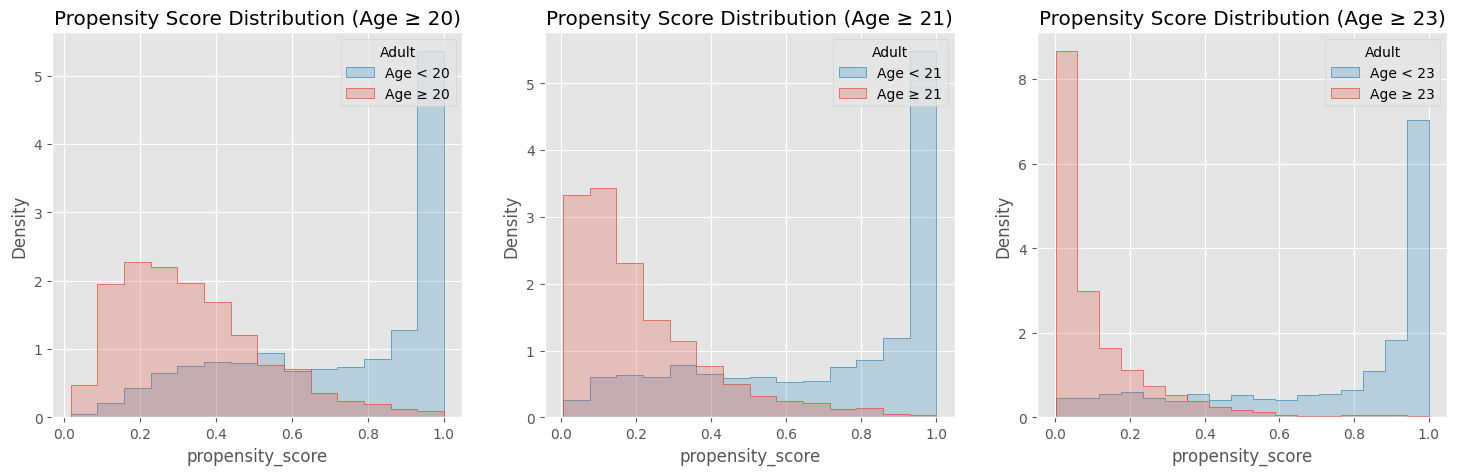

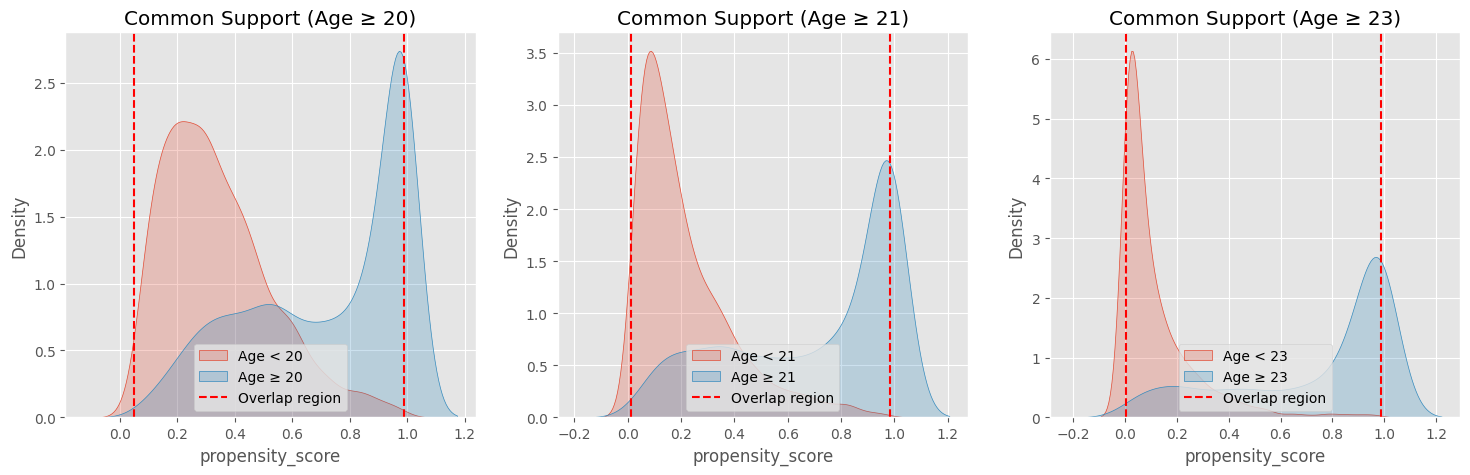

In [29]:
# Initialize subplots
fig_ps, axes_ps = plt.subplots(1, len(age_thresholds), figsize=(18, 5))
fig_cs, axes_cs = plt.subplots(1, len(age_thresholds), figsize=(18, 5))

for i, age_threshold in enumerate(age_thresholds):
    file_path = os.path.join(DATA_DIR, f"processed_age_{age_threshold}_outcome_strict.csv")
    X, t, y = read_and_transform_data(file_path)
    
    # Estimate propensity scores
    propensity_model = LogisticRegression(random_state=42, max_iter=1000)
    propensity_model.fit(X, t)
    propensity_scores = propensity_model.predict_proba(X)[:, 1]
    
    # Add propensity scores
    X['propensity_score'] = propensity_scores
    
    # Propensity score distribution (histogram)
    Xt = pd.concat([X, t], axis=1)
    sns.histplot(data=Xt, x='propensity_score', hue='Adult',
                 element='step', stat='density', common_norm=False, ax=axes_ps[i])
    axes_ps[i].set_title(f'Propensity Score Distribution (Age ≥ {age_threshold})')
    axes_ps[i].legend(title='Adult', labels=[f'Age < {age_threshold}', f'Age ≥ {age_threshold}'])

    # Common support
    min_treated = X[t == 1]['propensity_score'].min()
    max_treated = X[t == 1]['propensity_score'].max()
    min_untreated = X[t == 0]['propensity_score'].min()
    max_untreated = X[t == 0]['propensity_score'].max()
    
    overlap_min = max(min_treated, min_untreated)
    overlap_max = min(max_treated, max_untreated)
    
    print(f"\nAge ≥ {age_threshold}")
    print(f"Treated range: [{min_treated:.4f}, {max_treated:.4f}]")
    print(f"Untreated range: [{min_untreated:.4f}, {max_untreated:.4f}]")
    print("Common support holds." if min_treated <= max_untreated and min_untreated <= max_treated else "Common support may not hold.")
    
    # Common support visualization (KDE plot)
    sns.kdeplot(X[t == 0]['propensity_score'], label=f'Age < {age_threshold}', shade=True, ax=axes_cs[i])
    sns.kdeplot(X[t == 1]['propensity_score'], label=f'Age ≥ {age_threshold}', shade=True, ax=axes_cs[i])
    axes_cs[i].axvline(overlap_min, color='r', linestyle='--', label='Overlap region')
    axes_cs[i].axvline(overlap_max, color='r', linestyle='--')
    axes_cs[i].set_title(f'Common Support (Age ≥ {age_threshold})')
    axes_cs[i].legend()

plt.show()